Carregando e preparando os dados...
Função de features otimizada definida.
Criando as 504 colunas alvo para a previsão direta...
Dados de treino preparados com 4535 amostras.

Iniciando o treino dos 504 modelos 'especialistas'... Isso vai demorar.


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [00:37<00:00, 13.27it/s]


Treino e previsão concluídos em 0.63 minutos.

--- Resultado da Avaliação Justa (Direta) ---
MAE Final do LightGBM (Maratona Direta de 7 dias): 0.3214
MAE Final do ARIMAX (Maratona Recursiva de 7 dias): 0.3347


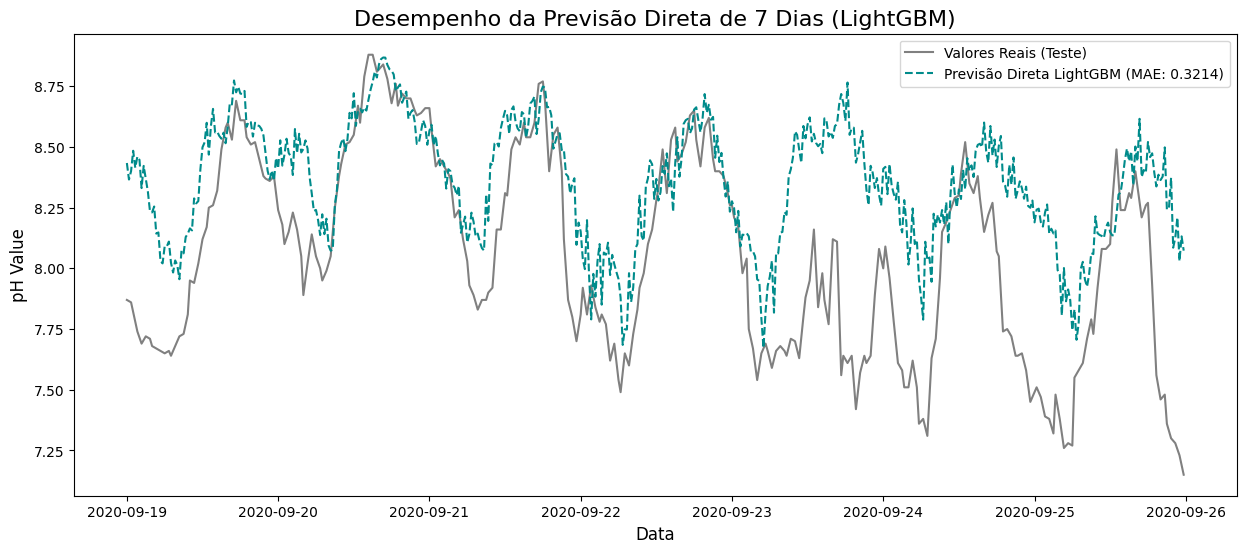

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm # Para a barra de progresso
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features Otimizada ---
def create_champion_features_optimized(df, target_variable='ph'):
    """
    Cria features de séries temporais de forma otimizada para evitar fragmentação.
    """
    df_copy = df.copy()
    features_list = []
    
    # Lags da variável alvo
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    for lag in lags_list:
        feature_lag = df_copy[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    # Features de Janela Deslizante
    window_sizes_list = [2, 4, 8]
    for window in window_sizes_list:
        feature_mean = df_copy[target_variable].rolling(window=window).mean()
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df_copy[target_variable].rolling(window=window).std()
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)

    # Juntar tudo de uma só vez
    df_featured = pd.concat([df_copy] + features_list, axis=1)
    return df_featured

print("Função de features otimizada definida.")
df_featured = create_champion_features_optimized(df, target_variable='ph')

# --- 3. Criação dos Alvos Multi-Step ---
print("Criando as 504 colunas alvo para a previsão direta...")
horizon = 7 * 24 * 3  # 504 passos
target_list = []
for i in range(1, horizon + 1):
    target_series = df_featured['ph'].shift(-i)
    target_series.name = f'ph_target_t+{i}'
    target_list.append(target_series)

# Juntar os alvos de uma só vez para eficiência
df_final = pd.concat([df_featured] + target_list, axis=1)

# Remover as linhas com NaNs (no início devido aos lags, no final devido aos alvos)
df_final = df_final.dropna()

# --- 4. Divisão Treino-Teste ---
# O X_test será apenas a última linha de dados com features válidas,
# a partir da qual faremos a previsão para o futuro.
train_df = df_final[:-1]
X_test_point = df_final.iloc[-1:]

FEATURES = [col for col in df.columns if col != 'ph'] # Features originais
X_train = train_df[FEATURES]
X_test = X_test_point[FEATURES]

print(f"Dados de treino preparados com {len(X_train)} amostras.")

# --- 5. Pipeline de Previsão Direta (A Equipa de Especialistas) ---
print(f"\nIniciando o treino dos {horizon} modelos 'especialistas'... Isso vai demorar.")
start_time = time.time()
predictions_direct = []

for i in tqdm(range(1, horizon + 1)):
    # Definir o alvo para este especialista
    target_col = f'ph_target_t+{i}'
    y_train_step = train_df[target_col]
    
    # Treinar o modelo especialista (usando o LightGBM otimizado)
    lgbm_specialist = lgb.LGBMRegressor(
        objective='mae', n_estimators=100, n_jobs=-1, verbose=-1, seed=42,
        learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0
    )
    lgbm_specialist.fit(X_train, y_train_step)
    
    # Fazer a previsão e guardá-la
    prediction = lgbm_specialist.predict(X_test)[0]
    predictions_direct.append(prediction)

end_time = time.time()
print(f"Treino e previsão concluídos em {(end_time - start_time)/60:.2f} minutos.")

# --- 6. Avaliação Final e Justa ---
true_values_test = df['ph'][-horizon:].values
mae_lgbm_direct = mean_absolute_error(true_values_test, predictions_direct)

print(f"\n--- Resultado da Avaliação Justa (Direta) ---")
print(f"MAE Final do LightGBM (Maratona Direta de 7 dias): {mae_lgbm_direct:.4f}")
print(f"MAE Final do ARIMAX (Maratona Recursiva de 7 dias): 0.3347")

# --- 7. Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(df.index[-horizon:], true_values_test, label='Valores Reais (Teste)', color='gray')
plt.plot(df.index[-horizon:], predictions_direct, label=f'Previsão Direta LightGBM (MAE: {mae_lgbm_direct:.4f})', color='darkcyan', linestyle='--')
plt.title('Desempenho da Previsão Direta de 7 Dias (LightGBM)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('pH Value', fontsize=12)
plt.legend()
plt.show()

Carregando e preparando os dados...
Criando as 504 colunas alvo para a previsão direta...
Dados de treino preparados com 4535 amostras.

Iniciando o treino dos 504 modelos 'especialistas' do XGBoost... Isso vai demorar.


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [02:11<00:00,  3.82it/s]


Treino e previsão concluídos em 2.20 minutos.

--- Resultado da Avaliação Justa (Direta) ---
MAE Final do XGBoost (Maratona Direta de 7 dias): 0.2265
MAE Final do ARIMAX (Maratona Recursiva de 7 dias): 0.3347


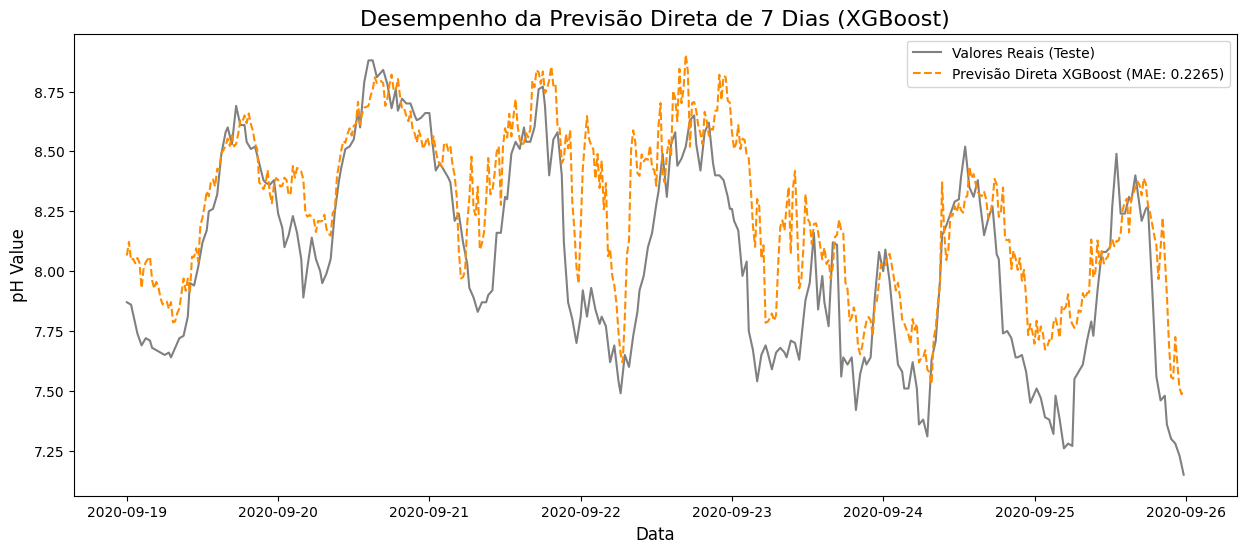

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm # Para a barra de progresso
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

def create_champion_features_optimized(df, target_variable='ph'):
    df_copy = df.copy()
    features_list = []
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    for lag in lags_list:
        feature_lag = df_copy[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
    for window in window_sizes_list:
        feature_mean = df_copy[target_variable].rolling(window=window).mean()
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        feature_std = df_copy[target_variable].rolling(window=window).std()
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)
    df_featured = pd.concat([df_copy] + features_list, axis=1)
    return df_featured

df_featured = create_champion_features_optimized(df, target_variable='ph')

# --- 2. Criação dos Alvos Multi-Step ---
print("Criando as 504 colunas alvo para a previsão direta...")
horizon = 7 * 24 * 3
target_list = []
for i in range(1, horizon + 1):
    target_series = df_featured['ph'].shift(-i)
    target_series.name = f'ph_target_t+{i}'
    target_list.append(target_series)
df_final = pd.concat([df_featured] + target_list, axis=1)
df_final = df_final.dropna()

# --- 3. Divisão Treino-Teste ---
train_df = df_final[:-1]
X_test_point = df_final.iloc[-1:]
FEATURES = [col for col in df.columns if col != 'ph']
X_train = train_df[FEATURES]
X_test = X_test_point[FEATURES]
print(f"Dados de treino preparados com {len(X_train)} amostras.")

# --- 4. Pipeline de Previsão Direta com XGBoost ---
print(f"\nIniciando o treino dos {horizon} modelos 'especialistas' do XGBoost... Isso vai demorar.")
start_time = time.time()
predictions_direct_xgb = []

for i in tqdm(range(1, horizon + 1)):
    # Definir o alvo para este especialista
    target_col = f'ph_target_t+{i}'
    y_train_step = train_df[target_col]
    
    # Treinar o modelo especialista (usando o XGBoost otimizado)
    xgb_specialist = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=100, n_jobs=-1, seed=42,
        learning_rate=0.05, max_depth=7, subsample=1.0, colsample_bytree=1.0
    )
    xgb_specialist.fit(X_train, y_train_step)
    
    # Fazer a previsão e guardá-la
    prediction = xgb_specialist.predict(X_test)[0]
    predictions_direct_xgb.append(prediction)

end_time = time.time()
print(f"Treino e previsão concluídos em {(end_time - start_time)/60:.2f} minutos.")

# --- 5. Avaliação Final e Justa ---
true_values_test = df['ph'][-horizon:].values
mae_xgb_direct = mean_absolute_error(true_values_test, predictions_direct_xgb)

print(f"\n--- Resultado da Avaliação Justa (Direta) ---")
print(f"MAE Final do XGBoost (Maratona Direta de 7 dias): {mae_xgb_direct:.4f}")
print(f"MAE Final do ARIMAX (Maratona Recursiva de 7 dias): 0.3347")

# --- 6. Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(df.index[-horizon:], true_values_test, label='Valores Reais (Teste)', color='gray')
plt.plot(df.index[-horizon:], predictions_direct_xgb, label=f'Previsão Direta XGBoost (MAE: {mae_xgb_direct:.4f})', color='darkorange', linestyle='--')
plt.title('Desempenho da Previsão Direta de 7 Dias (XGBoost)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('pH Value', fontsize=12)
plt.legend()
plt.show()